In [448]:
from PIL import Image
from PIL import Image, ImageChops, ImageEnhance
import torch
import numpy as np
from torchvision import transforms, datasets
import os
from tqdm import tqdm_notebook
import torchvision
from torch import nn
from torch.utils.data import Dataset, ConcatDataset,  SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, models
from torch.optim import lr_scheduler

import torch.nn as nn
import torch.nn.functional as F
import os
import cv2

torch.manual_seed(69)


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [471]:
def convert_to_ela(path, quality, fake, path_ = False):
  if not path_:
    resaved = '_resaved.jpeg'
    im = path.convert('RGB')
    path.save(resaved, 'JPEG', quality = quality)

  else:
    resaved = path.split('.')[0] + '_resaved.jpeg'
    ela_image_path = path.split('.')[0] + '_ela.png'
    im = Image.open(path).convert('RGB')
    im.save(resaved, 'JPEG', quality = quality )

  compressed_image = Image.open(resaved)
  os.remove(resaved)

  ela_im = ImageChops.difference(im, compressed_image)

  extrema = ela_im.getextrema()

  max_dif = max([ex[1] for ex in extrema])
  if max_dif == 0:
    max_diff = 1

  scale = 255.0 / max_dif

  ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)

  plt.subplot(1, 2, 1)
  plt.imshow(im)
  plt.title("Fake Image" if fake else "Image")
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(ela_im)
  plt.title("Fake Ela Image" if fake else "Ela Image")
  plt.axis('off')

  plt.show()








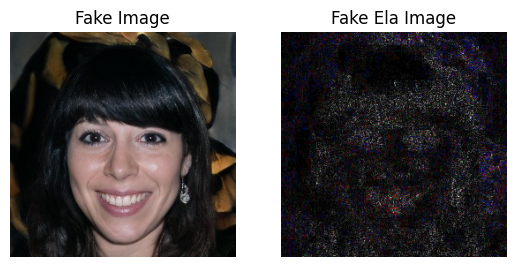

In [488]:
fake_image_path = '/content/drive/MyDrive/project DeepFakes/data/training/fake/0HXEUZMTWU.jpg'
real_image_path = '/content/drive/MyDrive/project DeepFakes/data/training/real/00003.jpg'

fake_img = Image.open(fake_image_path)
real_img = Image.open(real_image_path)

convert_to_ela(fake_image_path, 85, path_ = True, fake = True)


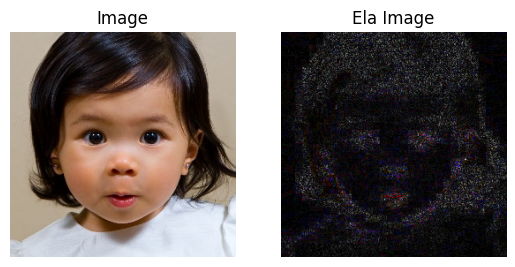

In [484]:
convert_to_ela(real_image_path, 85, path_ = True, fake = False)

In [356]:
transform = transforms.Compose(

    [
     transforms.Resize(256),
     #transforms.Lambda(lambda x: convert_to_ela(x, quality=90)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

transform2  = transforms.Compose(                      #for ela training

    [
     transforms.Resize(256),
     #transforms.Resize((224, 224)),
     transforms.Lambda(lambda x: convert_to_ela(x, quality=90)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [357]:
training_folder = '/content/drive/MyDrive/project DeepFakes/data/training'

trainset = datasets.ImageFolder(root=training_folder, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 2, shuffle = True)

test_folder = '/content/drive/MyDrive/project DeepFakes/data/validation'
testset = datasets.ImageFolder(root=test_folder, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 2, shuffle = False)

In [137]:
from torch import nn
from torch import flatten


class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 32, kernel_size = 7, stride = 3, padding=2),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels= 32 , out_channels = 64, kernel_size = 3, stride = 1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels= 64 , out_channels = 128, kernel_size = 3, stride = 1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels= 128 , out_channels = 128, kernel_size = 3, stride = 1, padding=1),

            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(128)

        self.classifier = nn.Sequential(
            nn.Linear(5 * 5 * 128, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )


        self.gradients = None


    def activations_hook(self, grad):
      self.gradients = grad

    def get_activations_gradient(self):
      return self.gradients

    def get_activations(self, x):
      return self.features(x)


    def forward(self, x):
        x = self.features(x)

        h = x.register_hook(self.activations_hook)
        x = self.bn(self.pool(x))

        x = x.view(-1, 5 * 5 * 128)
        x = self.classifier(x)

        return x

In [232]:
def train_model(model, loss_fn, optimizer, scheduler = None, num_epochs = 10, effnet = False):

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(10, 1, 1)

    best_model_wts = model.state_dict()
    best_acc = 0.0
    acc = []



    for epoch in tqdm_notebook(range(num_epochs)):

        if scheduler is not None:
          scheduler.step()
        running_loss = 0.0
        model.train()

        for i, batch in enumerate(tqdm_notebook(trainloader)):

            X_batch, y_batch = batch
            y_batch = y_batch.float()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            #X_batch.requires_grad_(True)

            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch.unsqueeze(1))

            if not effnet:
              loss.backward()
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f'Gradient for {name}: {param.grad.mean()}')

            optimizer.step()

            running_loss += loss.item()

            if i % 25 == 24:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 25))
                #losses.append(running_loss / 50)
                running_loss = 0.0


        class_correct = [0,0]
        class_total = [0,0]
        classes = ['Real', 'Fake']
        model.eval()


        for data in testloader:
            images, labels = data
            images = images.to(device)
            # images.requires_grad_(False)

            y_pred = model(images)

            predicted = torch.squeeze(torch.round(y_pred))

            c = predicted.cpu().detach() == labels

            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


        for i in range(2):
            print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))
        print(class_total)
        print(class_correct)
        print('Total Accuracy is: ', sum(class_correct) / sum(class_total))
        accuracy = sum(class_correct) / sum(class_total)
        acc.append( sum(class_correct) / sum(class_total))
        if accuracy > best_acc and accuracy > 0.86:
            best_acc = accuracy
            best_model_wts = model.state_dict()
            print("New Best Score!!! ")
            torch.save(model.state_dict(), 'effnet_' + str(accuracy) + '_on20epoch_adam(0.0001), batch_size = 16 Imagenet.pth')




    model.load_state_dict(best_model_wts)
    ax.plot(np.arange(len(acc)), acc)
    plt.show()
    return model, acc #ac




In [367]:
batch = []
net = ConvNet2().to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

#learning_rate = 0.001 #for adam
learning_rate = 0.000110246617213508516 #for adam
#learning_rate = 1.71903735673968e-05 #for RMS

optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#optimizer = torch.optim.RMSprop(net.parameters(), lr = learning_rate)
losses = []

<ipython-input-232-103b2016d28b>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-232-103b2016d28b>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/1551 [00:00<?, ?it/s]

[1,    25] loss: 0.606
[1,    50] loss: 0.710
[1,    75] loss: 0.786
[1,   100] loss: 0.700
[1,   125] loss: 0.676
[1,   150] loss: 0.701
[1,   175] loss: 0.703
[1,   200] loss: 0.683
[1,   225] loss: 0.682
[1,   250] loss: 0.693
[1,   275] loss: 0.670
[1,   300] loss: 0.681
[1,   325] loss: 0.715
[1,   350] loss: 0.677
[1,   375] loss: 0.672
[1,   400] loss: 0.679
[1,   425] loss: 0.679
[1,   450] loss: 0.705
[1,   475] loss: 0.675
[1,   500] loss: 0.691
[1,   525] loss: 0.695
[1,   550] loss: 0.686
[1,   575] loss: 0.674
[1,   600] loss: 0.691
[1,   625] loss: 0.698
[1,   650] loss: 0.682
[1,   675] loss: 0.684
[1,   700] loss: 0.665
[1,   725] loss: 0.694
[1,   750] loss: 0.688
[1,   775] loss: 0.706
[1,   800] loss: 0.685
[1,   825] loss: 0.674
[1,   850] loss: 0.705
[1,   875] loss: 0.699
[1,   900] loss: 0.663
[1,   925] loss: 0.659
[1,   950] loss: 0.704
[1,   975] loss: 0.692
[1,  1000] loss: 0.669
[1,  1025] loss: 0.674
[1,  1050] loss: 0.689
[1,  1075] loss: 0.670
[1,  1100] 

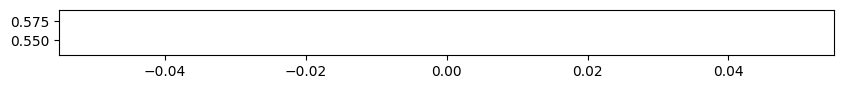

In [368]:
net, acc = train_model(net, loss_fn, optimizer, num_epochs = 1)

In [459]:
fake_path = '/content/drive/MyDrive/project DeepFakes/data/training/fake/easy_215_1111.jpg'
real_path = '/content/drive/MyDrive/project DeepFakes/data/training/real/00002.jpg'


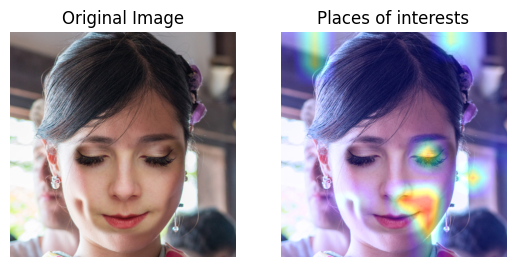

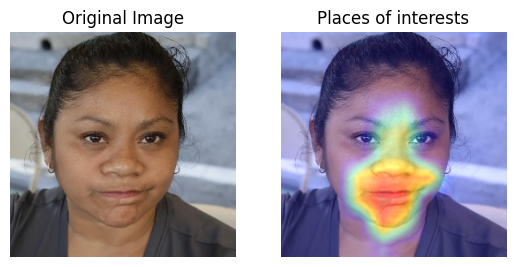

In [460]:
def plot_grad_cam(path):
      image = Image.open(path)
      transformed_image = transform(image)
      transformed_image = transformed_image.to(device).unsqueeze(0)

      pred = net(transformed_image).round()

      captured_gradients = net.get_activations_gradient()

      pooled_gradients = torch.mean(captured_gradients, dim = [0, 2, 3])
      activations = net.get_activations(transformed_image.to(device)).detach()

      for i in range(128):
        activations[:, i, :, :] *= pooled_gradients[i]

      activations
      heatmap = torch.mean(activations, dim=1).squeeze()
      heatmap = np.maximum(heatmap.cpu(), 0)
      heatmap /= torch.max(heatmap)
      channel_to_visualize = heatmap[ :, :]

      # plt.matshow(channel_to_visualize)   plot heatmap
      # plt.show()

      img = cv2.imread(path)
      heatmap = channel_to_visualize.numpy()
      heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
      heatmap = np.uint8(255 * heatmap)

      # Resize the heatmap to match the image dimensions #
      heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

      heat_pic = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

      superimposed_img = cv2.addWeighted(img, 1, heat_pic, 0.4, 0)

      plt.subplot(1, 2, 1)
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.title('Original Image')
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
      plt.title('Places of interests')
      plt.axis('off')

      plt.show()

plot_grad_cam(fake_path)
plot_grad_cam(real_path)